In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e2-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

snr_db_index = 2
snr_db=snr_db_array[snr_db_index]

Mounted at /content/drive


In [ ]:
num_samples = 100
sample_range = range(0, 100)

Sparse Bayesian Learning (SBL)

In [ ]:
def casbl_anc_algorithm(theta, y, noise_var, loc, alpha=0.5, beta=0.2, rho=7, U=20, max_iter=500, stopping_criterion=1e-4):
    """Correlation Aware Sparse Bayesian Learning (CASBL) for Multiple Measurement Vectors (MMV)."""

    M = y.shape[1]  # Number of antennas (columns of y)

    L = theta.shape[0]  # Pilot Length (rows of theta)
    N = theta.shape[1] # Number of MTDs (columns of theta)

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess

    if rho == 0:
        correlation_matrix = np.eye(N)  # Identity matrix when no correlation
    else:
        # Compute pairwise distances (N x N matrix)
        distance_matrix = np.linalg.norm(loc[:, np.newaxis, :] - loc[np.newaxis, :, :], axis=2)

        # Compute exponential decay matrix
        correlation_matrix = np.maximum((np.exp(-distance_matrix / rho) - np.exp(-U / rho)) / (1 - np.exp(-U / rho)),0)

    # Outer loop over the maximum number of iterations
    for t in range(max_iter):
        # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
        mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

        # Compute Q
        Q = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.diag(Sigma_x)

        # Compute P
        P = 2 * alpha * (beta - correlation_matrix) @ np.diag(Gamma)
        P = np.maximum(P, 1e-8)

        # Compute gamma update
        gamma_new = (np.sqrt(1 + 4 * P * Q) - 1) / (2 * P)

        # Ensure non-negativity (numerical stability)
        gamma_new = np.clip(np.real(gamma_new), 0, 1)

        # Update Gamma
        Gamma_old = np.diag(Gamma)
        Gamma = np.diagflat(gamma_new)

        # Check for convergence
        if np.linalg.norm(Gamma_old - gamma_new) < stopping_criterion:
            print(f"Converged after {t+1} outer iterations")
            break

    Gamma = np.where(Gamma < 0.05, 0, 1)

    Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
    mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

    return mu_x, np.diag(Gamma)  # Final estimates


In [ ]:
# Placeholder arrays for results
z_res = np.zeros((num_samples, len(pilot_length_array), device_count, M), dtype=np.complex128)  # Z estimates
gamma_res = np.zeros((num_samples, len(pilot_length_array), device_count), dtype=bool)  # Gamma support

hr_res = np.zeros((num_samples, len(pilot_length_array)))         # HR
fr_res = np.zeros((num_samples, len(pilot_length_array)))         # FR
srr_res = np.zeros((num_samples, len(pilot_length_array)))        # SRR
precision_res = np.zeros((num_samples, len(pilot_length_array)))  # Precision
recall_res = np.zeros((num_samples, len(pilot_length_array)))     # Recall
f1_res = np.zeros((num_samples, len(pilot_length_array)))         # F1
nmse_res = np.zeros((num_samples, len(pilot_length_array)))       # NMSE

In [ ]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(sample_range, desc="Processing Samples", position=0):
    gamma = all_gamma[sample_index]  # Ground truth gamma values (true support)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for pilot_length_index in tqdm(range(len(pilot_length_array)), desc="Processing Pilot Length Levels", leave=False, position=1):
        pilot_length = pilot_length_array[pilot_length_index]
        theta = all_theta[sample_index, pilot_length_index, :pilot_length]
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply SBL algorithm for the current sample and Pilot Length
        z_result, gamma_result = casbl_anc_algorithm(theta, received_signal, noise_power, loc)

        # Zero-out results with low gamma values
        z_result[gamma_result <= 0.05] = 0
        z_res[sample_index, pilot_length_index, :, :] = z_result
        gamma_result_bool =  gamma_result > 0.05
        gamma_res[sample_index, pilot_length_index, :] = gamma_result_bool

        # Compute number of active/inactive devices from ground truth
        active_devices = np.sum(gamma == 1)
        inactive_devices = np.sum(gamma == 0)

        # Hit rate: percentage of correctly identified active devices
        hr_res[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # False alarm rate: percentage of inactive devices wrongly detected as active
        fr_res[sample_index, pilot_length_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Support recovery rate: proportion of correctly identified active devices
        srr_res[sample_index, pilot_length_index] = (
            np.sum((gamma_result_bool == 1) & (gamma == 1)) /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Classification metrics: TP, FP, FN
        TP = np.sum((gamma_result_bool == 1) & (gamma == 1))
        FP = np.sum((gamma_result_bool == 1) & (gamma == 0))
        FN = np.sum((gamma_result_bool == 0) & (gamma == 1))

        # Precision: proportion of predicted active devices that are actually active
        precision_res[sample_index, pilot_length_index] = TP / (TP + FP) if (TP + FP) > 0 else 0

        # Recall: proportion of actual active devices that are correctly identified
        recall_res[sample_index, pilot_length_index] = TP / (TP + FN) if (TP + FN) > 0 else 0

        # F1 Score: harmonic mean of precision and recall
        if (precision_res[sample_index, pilot_length_index] + recall_res[sample_index, pilot_length_index]) > 0:
            f1_res[sample_index, pilot_length_index] = (
                2 * precision_res[sample_index, pilot_length_index] * recall_res[sample_index, pilot_length_index]
                /
                (precision_res[sample_index, pilot_length_index] + recall_res[sample_index, pilot_length_index])
            )
        else:
            f1_res[sample_index, pilot_length_index] = 0

        # Normalized Mean Squared Error: compares estimated and true z vectors for active devices
        nmse_res[sample_index, pilot_length_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )


Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:20<00:38, 19.48s/it]

Converged after 457 outer iterations



Processing Samples:   1%|          | 1/100 [02:02<3:21:43, 122.26s/it]

Converged after 401 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:39<00:20, 20.20s/it]

Converged after 444 outer iterations



Processing Samples:   2%|▏         | 2/100 [03:59<3:15:17, 119.57s/it]

Converged after 455 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:41<00:20, 20.79s/it]

Converged after 481 outer iterations



Processing Samples:   4%|▍         | 4/100 [08:01<3:11:56, 119.96s/it]

Converged after 330 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:18, 18.49s/it]

Converged after 378 outer iterations



Processing Samples:   5%|▌         | 5/100 [09:59<3:08:43, 119.19s/it]

Converged after 499 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:19, 19.06s/it]

Converged after 415 outer iterations



Processing Samples:   6%|▌         | 6/100 [11:48<3:01:23, 115.78s/it]

Converged after 331 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:16<00:39, 19.51s/it]

Converged after 490 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:38<00:20, 20.31s/it]

Converged after 473 outer iterations



Processing Samples:   7%|▋         | 7/100 [13:48<3:01:36, 117.16s/it]

Converged after 440 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:18, 18.79s/it]

Converged after 408 outer iterations



Processing Samples:   9%|▉         | 9/100 [17:50<3:00:13, 118.83s/it]

Converged after 418 outer iterations



Processing Samples:  10%|█         | 10/100 [19:46<2:56:58, 117.98s/it]

Converged after 372 outer iterations



Processing Samples:  11%|█         | 11/100 [21:44<2:55:23, 118.24s/it]

Converged after 444 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:40<00:19, 19.95s/it]

Converged after 425 outer iterations



Processing Samples:  12%|█▏        | 12/100 [23:40<2:52:07, 117.36s/it]

Converged after 347 outer iterations



Processing Samples:  13%|█▎        | 13/100 [25:38<2:50:36, 117.67s/it]

Converged after 327 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:38<00:19, 19.94s/it]

Converged after 489 outer iterations



Processing Samples:  14%|█▍        | 14/100 [27:39<2:50:05, 118.67s/it]

Converged after 445 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:36<00:19, 19.27s/it]

Converged after 457 outer iterations



Processing Samples:  15%|█▌        | 15/100 [29:30<2:44:40, 116.24s/it]

Converged after 304 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:16<00:37, 18.84s/it]

Converged after 431 outer iterations
Converged after 434 outer iterations



Processing Samples:  16%|█▌        | 16/100 [31:27<2:42:59, 116.42s/it]

Converged after 464 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:18, 18.62s/it]

Converged after 400 outer iterations



Processing Samples:  17%|█▋        | 17/100 [33:18<2:38:58, 114.92s/it]

Converged after 361 outer iterations



Processing Samples:  18%|█▊        | 18/100 [35:13<2:37:10, 115.00s/it]

Converged after 346 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.24s/it]

Converged after 372 outer iterations



Processing Samples:  19%|█▉        | 19/100 [37:09<2:35:44, 115.37s/it]

Converged after 475 outer iterations



Processing Samples:  20%|██        | 20/100 [39:05<2:33:46, 115.33s/it]

Converged after 392 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:38<00:19, 19.52s/it]

Converged after 438 outer iterations



Processing Samples:  21%|██        | 21/100 [40:59<2:31:26, 115.02s/it]

Converged after 351 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:17<00:38, 19.27s/it]

Converged after 454 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:38<00:19, 19.70s/it]

Converged after 453 outer iterations



Processing Samples:  23%|██▎       | 23/100 [44:57<2:29:51, 116.77s/it]

Converged after 355 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:37<00:19, 19.96s/it]

Converged after 477 outer iterations



Processing Samples:  24%|██▍       | 24/100 [46:50<2:26:19, 115.52s/it]

Converged after 354 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:15<00:37, 18.73s/it]

Converged after 455 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:17, 17.64s/it]

Converged after 380 outer iterations



Processing Samples:  25%|██▌       | 25/100 [48:39<2:22:04, 113.66s/it]

Converged after 407 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:38<00:19, 19.78s/it]

Converged after 479 outer iterations



Processing Samples:  26%|██▌       | 26/100 [50:33<2:20:10, 113.66s/it]

Converged after 361 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:36<00:19, 19.38s/it]

Converged after 453 outer iterations



Processing Samples:  27%|██▋       | 27/100 [52:27<2:18:30, 113.85s/it]

Converged after 358 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:38<00:20, 20.00s/it]

Converged after 469 outer iterations



Processing Samples:  28%|██▊       | 28/100 [54:19<2:15:59, 113.33s/it]

Converged after 317 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:17<00:38, 19.30s/it]

Converged after 490 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:18, 18.53s/it]

Converged after 423 outer iterations



Processing Samples:  29%|██▉       | 29/100 [56:15<2:14:56, 114.03s/it]

Converged after 424 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:36<00:19, 19.15s/it]

Converged after 440 outer iterations



Processing Samples:  30%|███       | 30/100 [58:10<2:13:19, 114.28s/it]

Converged after 424 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:20<00:40, 20.44s/it]

Converged after 481 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:36<00:18, 18.79s/it]

Converged after 385 outer iterations



Processing Samples:  31%|███       | 31/100 [1:00:01<2:10:25, 113.42s/it]

Converged after 342 outer iterations



Processing Samples:  32%|███▏      | 32/100 [1:02:01<2:10:38, 115.27s/it]

Converged after 445 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:19, 19.07s/it]

Converged after 453 outer iterations



Processing Samples:  33%|███▎      | 33/100 [1:03:53<2:07:42, 114.37s/it]

Converged after 379 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:39<00:19, 19.99s/it]

Converged after 471 outer iterations



Processing Samples:  34%|███▍      | 34/100 [1:05:48<2:05:57, 114.50s/it]

Converged after 349 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:37, 18.69s/it]

Converged after 411 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.58s/it]

Converged after 374 outer iterations



Processing Samples:  35%|███▌      | 35/100 [1:07:35<2:01:47, 112.42s/it]

Converged after 405 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:39<00:20, 20.19s/it]

Converged after 448 outer iterations



Processing Samples:  36%|███▌      | 36/100 [1:09:34<2:01:55, 114.30s/it]

Converged after 457 outer iterations



Processing Samples:  37%|███▋      | 37/100 [1:11:33<2:01:25, 115.64s/it]

Converged after 394 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:43<00:21, 21.42s/it]

Converged after 485 outer iterations



Processing Samples:  38%|███▊      | 38/100 [1:13:32<2:00:41, 116.79s/it]

Converged after 379 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:15<00:38, 19.44s/it]

Converged after 446 outer iterations



Processing Samples:  39%|███▉      | 39/100 [1:15:25<1:57:28, 115.56s/it]

Converged after 413 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:16<00:37, 18.87s/it]

Converged after 462 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:31<00:17, 17.45s/it]

Converged after 359 outer iterations



Processing Samples:  41%|████      | 41/100 [1:19:22<1:55:31, 117.49s/it]

Converged after 462 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:19, 19.07s/it]

Converged after 472 outer iterations



Processing Samples:  42%|████▏     | 42/100 [1:21:21<1:53:56, 117.87s/it]

Converged after 480 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:18, 18.44s/it]

Converged after 340 outer iterations



Processing Samples:  43%|████▎     | 43/100 [1:23:11<1:49:46, 115.55s/it]

Converged after 353 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:57<00:58, 19.35s/it]

Converged after 484 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:37<00:19, 19.82s/it]

Converged after 456 outer iterations



Processing Samples:  44%|████▍     | 44/100 [1:25:04<1:47:06, 114.77s/it]

Converged after 350 outer iterations



Processing Samples:  45%|████▌     | 45/100 [1:26:59<1:45:09, 114.71s/it]

Converged after 363 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:22<00:41, 20.56s/it]

Converged after 441 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:40<00:19, 19.46s/it]

Converged after 431 outer iterations



Processing Samples:  46%|████▌     | 46/100 [1:28:56<1:44:02, 115.59s/it]

Converged after 422 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:17<00:38, 19.49s/it]

Converged after 391 outer iterations



Processing Samples:  47%|████▋     | 47/100 [1:30:50<1:41:42, 115.13s/it]

Converged after 398 outer iterations



Processing Samples:  48%|████▊     | 48/100 [1:32:44<1:39:16, 114.55s/it]

Converged after 373 outer iterations



Processing Samples:  49%|████▉     | 49/100 [1:34:41<1:37:59, 115.29s/it]

Converged after 321 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:18, 18.92s/it]

Converged after 452 outer iterations



Processing Samples:  50%|█████     | 50/100 [1:36:37<1:36:27, 115.76s/it]

Converged after 466 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:55<00:56, 18.93s/it]

Converged after 467 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:37<00:19, 19.76s/it]

Converged after 430 outer iterations



Processing Samples:  51%|█████     | 51/100 [1:38:30<1:33:44, 114.78s/it]

Converged after 321 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:38<00:19, 19.56s/it]

Converged after 413 outer iterations



Processing Samples:  52%|█████▏    | 52/100 [1:40:25<1:31:52, 114.85s/it]

Converged after 401 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:19, 19.10s/it]

Converged after 451 outer iterations



Processing Samples:  53%|█████▎    | 53/100 [1:42:20<1:30:02, 114.94s/it]

Converged after 393 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:37<00:19, 19.45s/it]

Converged after 419 outer iterations



Processing Samples:  54%|█████▍    | 54/100 [1:44:12<1:27:31, 114.17s/it]

Converged after 336 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:40<00:20, 20.59s/it]

Converged after 478 outer iterations



Processing Samples:  55%|█████▌    | 55/100 [1:46:12<1:26:50, 115.79s/it]

Converged after 451 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:15<00:37, 18.76s/it]

Converged after 475 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.45s/it]

Converged after 362 outer iterations



Processing Samples:  56%|█████▌    | 56/100 [1:48:00<1:23:05, 113.30s/it]

Converged after 407 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.44s/it]

Converged after 380 outer iterations



Processing Samples:  58%|█████▊    | 58/100 [1:51:59<1:21:10, 115.96s/it]

Converged after 488 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:42<00:20, 20.68s/it]

Converged after 475 outer iterations



Processing Samples:  60%|██████    | 60/100 [1:56:00<1:18:27, 117.69s/it]

Converged after 391 outer iterations



Processing Samples:  61%|██████    | 61/100 [1:57:56<1:16:08, 117.14s/it]

Converged after 373 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:18<00:37, 18.99s/it]

Converged after 440 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:41<00:20, 20.22s/it]

Converged after 461 outer iterations



Processing Samples:  62%|██████▏   | 62/100 [1:59:52<1:14:01, 116.87s/it]

Converged after 344 outer iterations



Processing Samples:  63%|██████▎   | 63/100 [2:01:46<1:11:33, 116.04s/it]

Converged after 396 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:20<00:40, 20.28s/it]

Converged after 479 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:40<00:20, 20.40s/it]

Converged after 469 outer iterations



Processing Samples:  64%|██████▍   | 64/100 [2:03:43<1:09:47, 116.31s/it]

Converged after 382 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:18, 18.20s/it]

Converged after 370 outer iterations



Processing Samples:  65%|██████▌   | 65/100 [2:05:30<1:06:09, 113.40s/it]

Converged after 312 outer iterations



Processing Samples:  66%|██████▌   | 66/100 [2:07:24<1:04:27, 113.76s/it]

Converged after 322 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:38<00:20, 20.30s/it]

Converged after 482 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:14<00:37, 18.68s/it]

Converged after 420 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:19, 19.06s/it]

Converged after 482 outer iterations



Processing Samples:  68%|██████▊   | 68/100 [2:11:22<1:01:47, 115.86s/it]

Converged after 402 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:16<00:39, 19.75s/it]

Converged after 489 outer iterations



Processing Samples:  69%|██████▉   | 69/100 [2:13:15<59:27, 115.10s/it]  

Converged after 392 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:23<00:41, 20.59s/it]

Converged after 451 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:40<00:19, 19.59s/it]

Converged after 447 outer iterations



Processing Samples:  70%|███████   | 70/100 [2:15:12<57:52, 115.75s/it]

Converged after 385 outer iterations



Processing Samples:  71%|███████   | 71/100 [2:17:08<55:58, 115.80s/it]

Converged after 335 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:19<00:41, 20.82s/it]

Converged after 489 outer iterations



Processing Samples:  72%|███████▏  | 72/100 [2:19:08<54:39, 117.11s/it]

Converged after 442 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:35<00:19, 19.56s/it]

Converged after 450 outer iterations



Processing Samples:  73%|███████▎  | 73/100 [2:21:02<52:14, 116.08s/it]

Converged after 437 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:18<00:38, 19.34s/it]

Converged after 494 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:38<00:19, 19.47s/it]

Converged after 403 outer iterations



Processing Samples:  75%|███████▌  | 75/100 [2:25:00<48:54, 117.39s/it]

Converged after 481 outer iterations



Processing Samples:  76%|███████▌  | 76/100 [2:26:59<47:10, 117.94s/it]

Converged after 448 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:20<00:41, 20.82s/it]

Converged after 497 outer iterations



Processing Samples:  77%|███████▋  | 77/100 [2:29:00<45:31, 118.77s/it]

Converged after 404 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.07s/it]

Converged after 382 outer iterations



Processing Pilot Length Levels: 100%|██████████| 6/6 [01:50<00:00, 17.84s/it]
                                                                             

Converged after 388 outer iterations


Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:39<00:19, 19.98s/it]

Converged after 463 outer iterations



Processing Samples:  79%|███████▉  | 79/100 [2:32:45<40:30, 115.75s/it]

Converged after 344 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:42<00:20, 20.56s/it]

Converged after 492 outer iterations



Processing Samples:  80%|████████  | 80/100 [2:34:45<39:03, 117.18s/it]

Converged after 424 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:58<00:58, 19.34s/it]

Converged after 498 outer iterations



Processing Samples:  81%|████████  | 81/100 [2:36:43<37:09, 117.33s/it]

Converged after 406 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:16<00:38, 19.03s/it]

Converged after 470 outer iterations



Processing Samples:  82%|████████▏ | 82/100 [2:38:42<35:21, 117.87s/it]

Converged after 379 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:16<00:38, 19.14s/it]

Converged after 464 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.50s/it]

Converged after 400 outer iterations



Processing Samples:  83%|████████▎ | 83/100 [2:40:32<32:43, 115.50s/it]

Converged after 394 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:37<00:19, 19.64s/it]

Converged after 434 outer iterations



Processing Samples:  84%|████████▍ | 84/100 [2:42:25<30:35, 114.72s/it]

Converged after 369 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:17<00:37, 18.78s/it]

Converged after 404 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:36<00:18, 18.84s/it]

Converged after 479 outer iterations



Processing Samples:  85%|████████▌ | 85/100 [2:44:16<28:24, 113.66s/it]

Converged after 333 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:39<00:19, 19.52s/it]

Converged after 431 outer iterations



Processing Samples:  86%|████████▌ | 86/100 [2:46:12<26:39, 114.27s/it]

Converged after 396 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:32<00:17, 17.89s/it]

Converged after 374 outer iterations



Processing Samples:  87%|████████▋ | 87/100 [2:48:08<24:54, 114.94s/it]

Converged after 380 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:13<00:36, 18.23s/it]

Converged after 409 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:30<00:17, 17.72s/it]

Converged after 416 outer iterations



Processing Samples:  88%|████████▊ | 88/100 [2:49:54<22:27, 112.25s/it]

Converged after 370 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:38<00:20, 20.08s/it]

Converged after 453 outer iterations



Processing Samples:  89%|████████▉ | 89/100 [2:51:52<20:53, 113.92s/it]

Converged after 467 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [01:00<01:03, 21.02s/it]

Converged after 487 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:37<00:19, 19.15s/it]

Converged after 396 outer iterations



Processing Samples:  90%|█████████ | 90/100 [2:53:52<19:17, 115.78s/it]

Converged after 480 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:56<00:57, 19.19s/it]

Converged after 474 outer iterations



Processing Samples:  91%|█████████ | 91/100 [2:55:53<17:34, 117.17s/it]

Converged after 454 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:18, 18.79s/it]

Converged after 430 outer iterations



Processing Samples:  92%|█████████▏| 92/100 [2:57:50<15:37, 117.18s/it]

Converged after 366 outer iterations



Processing Pilot Length Levels:  50%|█████     | 3/6 [00:52<00:52, 17.39s/it]

Converged after 446 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:19, 19.14s/it]

Converged after 468 outer iterations



Processing Samples:  93%|█████████▎| 93/100 [2:59:42<13:30, 115.76s/it]

Converged after 463 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:37<00:19, 19.33s/it]

Converged after 434 outer iterations



Processing Samples:  94%|█████████▍| 94/100 [3:01:36<11:30, 115.04s/it]

Converged after 366 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:19<00:40, 20.35s/it]

Converged after 465 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:33<00:18, 18.23s/it]

Converged after 399 outer iterations



Processing Samples:  96%|█████████▌| 96/100 [3:05:27<07:40, 115.00s/it]

Converged after 371 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:38<00:19, 19.45s/it]

Converged after 429 outer iterations



Processing Samples:  97%|█████████▋| 97/100 [3:07:26<05:47, 115.93s/it]

Converged after 369 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:39<00:19, 19.99s/it]

Converged after 484 outer iterations



Processing Samples:  98%|█████████▊| 98/100 [3:09:25<03:53, 116.83s/it]

Converged after 466 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:40<00:20, 20.17s/it]

Converged after 499 outer iterations



Processing Samples:  99%|█████████▉| 99/100 [3:11:20<01:56, 116.46s/it]

Converged after 347 outer iterations



Processing Pilot Length Levels:  67%|██████▋   | 4/6 [01:18<00:39, 19.78s/it]

Converged after 468 outer iterations



Processing Pilot Length Levels:  83%|████████▎ | 5/6 [01:34<00:18, 18.30s/it]

Converged after 378 outer iterations



Processing Samples: 100%|██████████| 100/100 [3:13:09<00:00, 115.90s/it]

Converged after 324 outer iterations


In [ ]:
# Compute the average across all samples for each SNR level
avg_hr = np.mean(hr_res, axis=0)         # HR
avg_srr = np.mean(srr_res, axis=0)       # SRR
avg_fr = np.mean(fr_res, axis=0)         # FR
avg_pr = np.mean(precision_res, axis=0)  # Precision
avg_re = np.mean(recall_res, axis=0)     # Recall
avg_f1 = np.mean(f1_res, axis=0)         # F1
avg_nmse = np.mean(nmse_res, axis=0)     # NMSE

# Print average results
print("Avg HR  :", avg_hr)
print("Avg SRR :", avg_srr)
print("Avg FR  :", avg_fr)
print("Avg PR  :", avg_pr)
print("Avg RE  :", avg_re)
print("Avg F1  :", avg_f1)
print("Avg NMSE:", avg_nmse)

Avg HR  : [66.85 85.55 95.7  98.9  99.65 99.7 ]
Avg SRR : [0.37093743 0.56690773 0.75780653 0.87658636 0.9431917  0.96419066]
Avg FR  : [2.91052632 2.21842105 1.28947368 0.65263158 0.29736842 0.17368421]
Avg PR  : [0.55287433 0.67922444 0.80429348 0.89264716 0.94897299 0.96956183]
Avg RE  : [0.6685 0.8555 0.957  0.989  0.9965 0.997 ]
Avg F1  : [0.60375622 0.75529199 0.87202622 0.93722064 0.97147593 0.98266106]
Avg NMSE: [0.56763702 0.35898897 0.18190856 0.09984546 0.06543756 0.05056283]


In [ ]:
np.savez_compressed(
    '/content/drive/My Drive/Github/mtc-device-activation/data/results/e2-results-100-casbl-anc-alpha-0-50-beta-0-20-snr-db-12-pilot-length-all.npz',
    z_res=z_res,
    gamma_res=gamma_res,
    hr_res=hr_res,
    fr_res=fr_res,
    srr_res=srr_res,
    precision_res=precision_res,
    recall_res=recall_res,
    f1_res=f1_res,
    nmse_res=nmse_res,
    avg_hr=avg_hr,
    avg_fr=avg_fr,
    avg_srr=avg_srr,
    avg_pr=avg_pr,
    avg_re=avg_re,
    avg_f1=avg_f1,
    avg_nmse=avg_nmse,
    pilot_length_array=pilot_length_array,
    snr_db=snr_db
)

print("All results have been saved")

All results have been saved


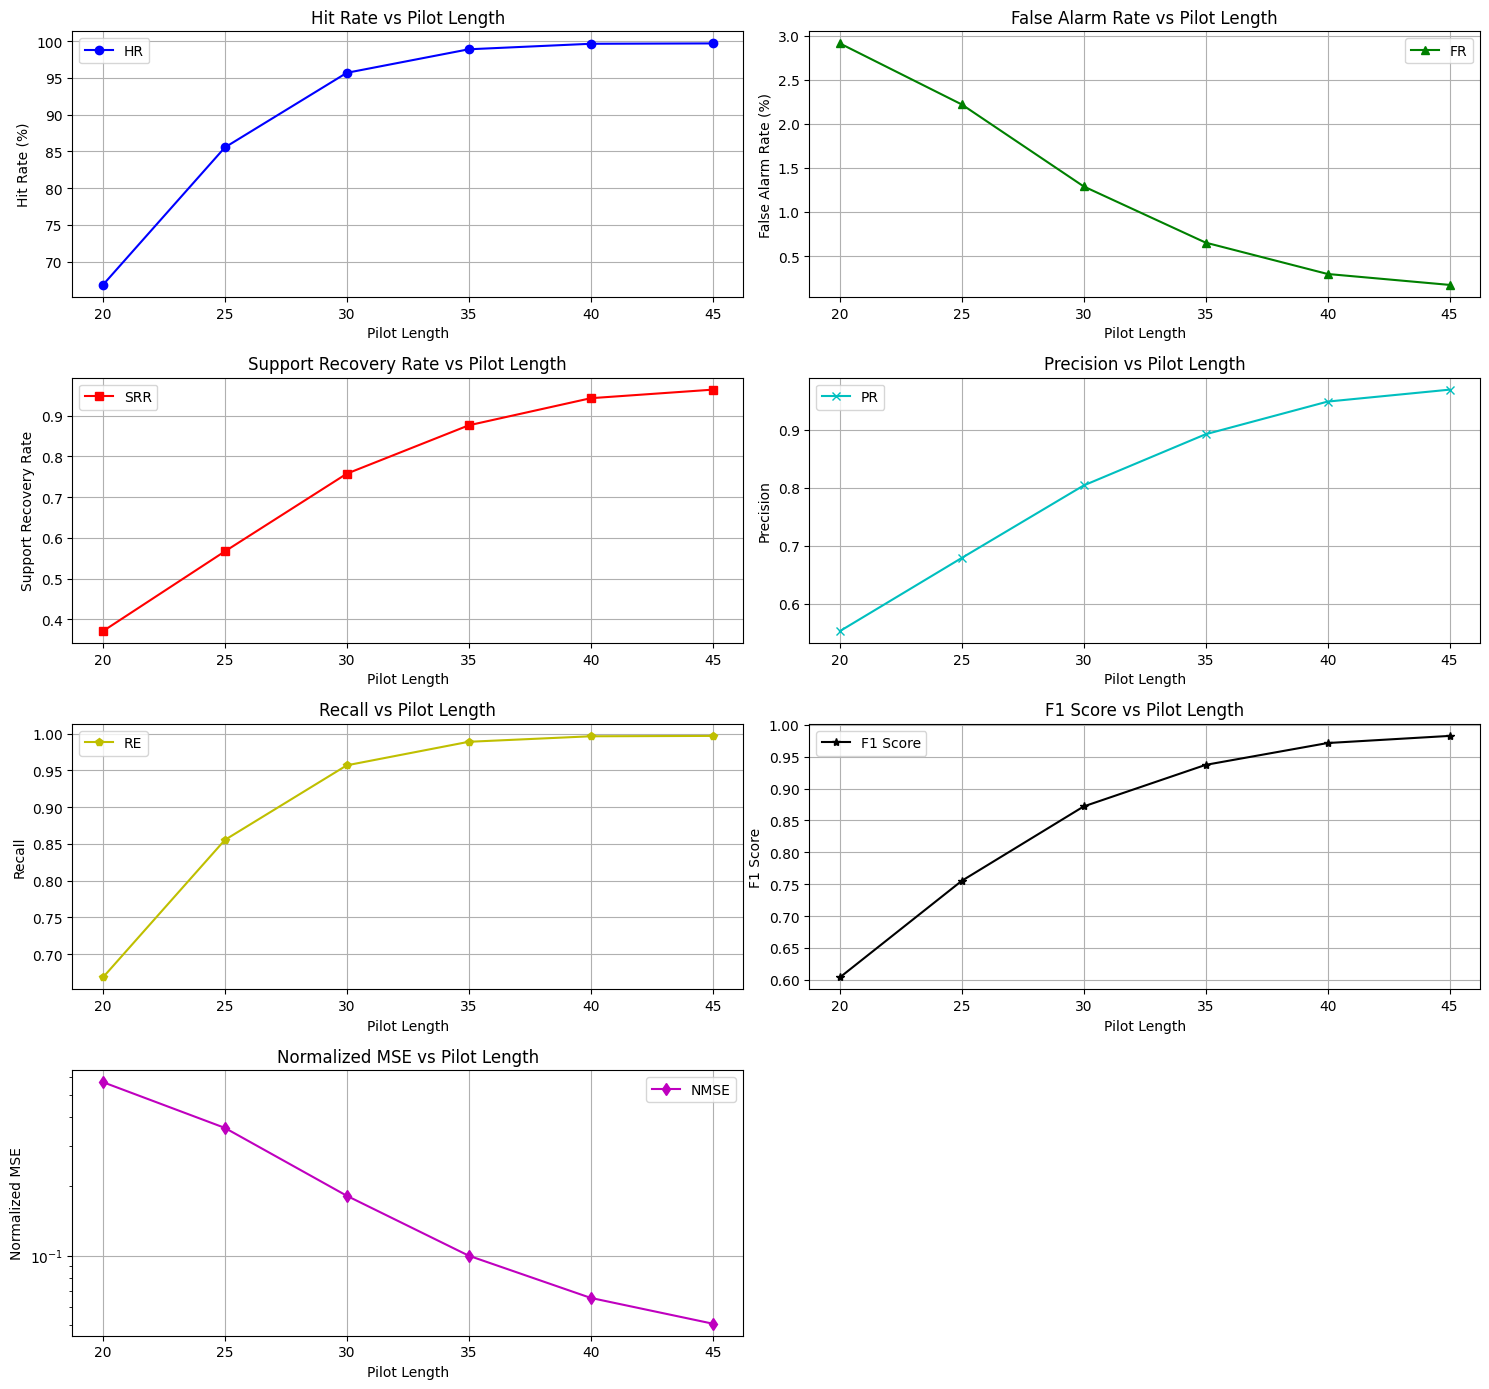

In [ ]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
pilot_length_values = pilot_length_array

# Create subplots for different performance metrics
plt.figure(figsize=(15, 14))

# Plot Hit Rate (HR)
plt.subplot(4, 2, 1)
plt.plot(pilot_length_values, avg_hr, marker='o', linestyle='-', color='b', label='HR')
plt.xlabel("Pilot Length")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate (FR)
plt.subplot(4, 2, 2)
plt.plot(pilot_length_values, avg_fr, marker='^', linestyle='-', color='g', label='FR')
plt.xlabel("Pilot Length")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Support Recovery Rate (SRR)
plt.subplot(4, 2, 3)
plt.plot(pilot_length_values, avg_srr, marker='s', linestyle='-', color='r', label='SRR')
plt.xlabel("Pilot Length")
plt.ylabel("Support Recovery Rate")
plt.title("Support Recovery Rate vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Precision (PR)
plt.subplot(4, 2, 4)
plt.plot(pilot_length_values, avg_pr, marker='x', linestyle='-', color='c', label='PR')
plt.xlabel("Pilot Length")
plt.ylabel("Precision")
plt.title("Precision vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Recall (RE)
plt.subplot(4, 2, 5)
plt.plot(pilot_length_values, avg_re, marker='p', linestyle='-', color='y', label='RE')
plt.xlabel("Pilot Length")
plt.ylabel("Recall")
plt.title("Recall vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot F1 Score (F1)
plt.subplot(4, 2, 6)
plt.plot(pilot_length_values, avg_f1, marker='*', linestyle='-', color='k', label='F1 Score')
plt.xlabel("Pilot Length")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Pilot Length")
plt.grid(True)
plt.legend()

# Plot Normalized MSE (NMSE)
plt.subplot(4, 2, 7)
plt.plot(pilot_length_values, avg_nmse, marker='d', linestyle='-', color='m', label='NMSE')
plt.xlabel("Pilot Length")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs Pilot Length")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_res_vs_ground_truth(sbl_results, Z, sample_index, snr_index, snr_value):
    """Plot sbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # sbl Estimated Signal
    plt.plot(np.abs(sbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="sbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"sbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

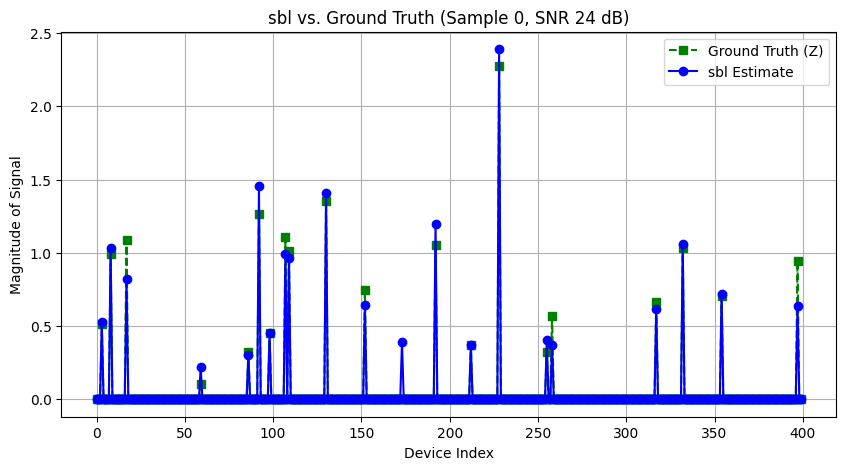

In [ ]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_res_vs_ground_truth(z_res, all_z, sample_index, snr_index, snr_value)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_res_vs_ground_truth(gamma_res, gamma_true, sample_index, snr_index, snr_value):
    """Plot sbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot sbl estimated gamma
    plt.stem(device_indices, gamma_res[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="sbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (sbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


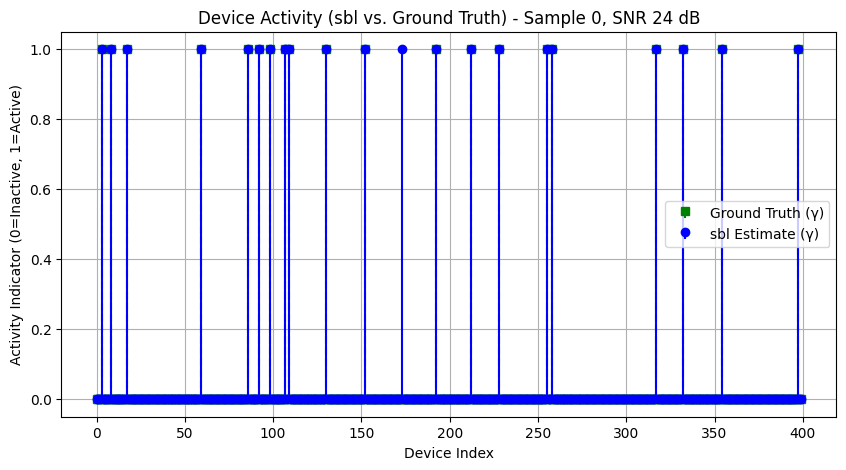

In [ ]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_res_vs_ground_truth(gamma_res, all_gamma, sample_index, snr_index, snr_value)